In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, re, datetime, random, gzip, json, copy
import tqdm
import pandas as pd
import numpy as np
import glob
from pathlib import Path
from itertools import accumulate
import argparse
from time import time
from math import ceil
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import xgboost as xgb
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve
from sklearn.utils import class_weight

PROJ_PATH = Path(os.path.join(re.sub("/TS-IDS.*$", '', os.getcwd()), 'TS-IDS'))
print(f'PROJ_PATH={PROJ_PATH}')
sys.path.insert(1, str(PROJ_PATH))
sys.path.insert(1, str(PROJ_PATH/'src'))
import utils

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

/home/hoang/miniconda2/envs/iot/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


PROJ_PATH=/home/hoang/github/TS-IDS


In [2]:
def read_output(ds_file, pred_path):
    # label mapping
    g_data = pd.read_pickle(ds_file)
    label2idx = g_data['label2idx']
    idx2label = {j:i for i,j in label2idx.items()}
    # df output
    df = pd.read_csv(pred_path)
    prob_cnames = [c for c in df.columns if c.startswith('probs')]
    df['True label'] = df['gts'].map(idx2label)
    # df test
    df_test = df[df['tvt']=='test']
    probs_cnames = [c for c in df_test.columns if c.startswith('probs_')]

    if len(probs_cnames) == 2:
        probs = df_test['probs_1']
        df_test.loc[:, 'True label'] = df_test.loc[:,'True label'].map({0: 'Normal', 1: 'Attack'})
        optimal_threshold = find_optimal_cutoff(df_test['gts'], df_test['probs_1'])
        df_test['pred'] = (df_test['probs_1']>optimal_threshold).astype(int)
        df_test.loc[:, 'Predicted label'] = df_test.loc[:,'pred'].map({0: 'Normal', 1: 'Attack'})
        binary = True
    else:
        probs = df_test[probs_cnames].values
        df_test.loc[:,'pred'] = df_test.loc[:,prob_cnames].values.argmax(axis=1)
        df_test.loc[:,'Predicted label'] = df_test.loc[:,'pred'].map(idx2label)
        binary = False
    
    gts = df_test['gts'].values
    preds = df_test['pred'].values
    
    return df_test, gts, probs, preds, binary

def find_optimal_cutoff(target, predicted):
    fpr, tpr, thresholds = roc_curve(target, predicted)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

def calc_auc(gts, probs, avg_type='macro', binary=False):
    if binary:
        auc = roc_auc_score(gts, preds)
    else: 
        auc = roc_auc_score(
            gts, 
            probs, 
            average=avg_type, 
            multi_class='ovo', 
        )
    return auc

def calc_eval(gts, probs, preds, binary):
    acc = accuracy_score(gts, preds)
    auc = calc_auc(gts, probs, binary=binary)
    precision_macro = precision_score(gts, preds, average='macro', zero_division=0)
    precision_micro = precision_score(gts, preds, average='micro', zero_division=0)
    recall_macro = recall_score(gts, preds, average='macro', zero_division=0)
    recall_micro = recall_score(gts, preds, average='micro', zero_division=0)
    f1_macro = f1_score(gts, preds, average='macro', zero_division=0)
    f1_micro = f1_score(gts, preds, average='micro', zero_division=0)
    return acc, auc, precision_macro, precision_micro, recall_macro, recall_micro, f1_macro, f1_micro

def plot_confusion_matrix(df_test):
    # https://seaborn.pydata.org/tutorial/color_palettes.html
    fontsize = 14
    fig, ax = plt.subplots(figsize=(10,7))
    tdf = df_test.pivot_table(
        index='True label', columns='Predicted label', values='probs_0', aggfunc='count', fill_value=0.0)
    
    ## Handle missing cols
    missing_cols = set(tdf.index) - set(tdf.columns)
    for col in missing_cols:
        tdf[col] = [0] * tdf.shape[0]
    tdf = tdf.reindex(sorted(tdf.columns), axis=1)
    tdf = tdf.sort_index()
    
    g = sns.heatmap(
        tdf, ax=ax, annot=True, fmt=".0f", cmap="flare", linewidth=.5, 
        xticklabels=tdf.columns, yticklabels=tdf.columns)
    g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=fontsize)
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=fontsize)
    g.set_xlabel(g.get_xlabel(), fontsize=fontsize)
    g.set_ylabel(g.get_ylabel(), fontsize=fontsize)
    plt.show()

In [3]:
metrics = [
    'acc', 'auc', 'precision_macro', 'precision_micro', 
    'recall_macro', 'recall_micro', 'f1_macro', 'f1_micro',
]

# Not cv

In [ ]:
datasets = {
    'nf_bot_binary': 'NF-BoT-IoT_graph_binary',
    'nf_bot_multi': 'NF-BoT-IoT_graph_multi',
    'nf_ton_binary': 'NF-ToN-IoT_graph_binary',
    'nf_ton_multi': 'NF-ToN-IoT_graph_multi',
}
models = ['xgb', 'EGraphSAGE', 'tsids']
results = []
cm_matrices = []
for model in models:
    print(model)
    for ds, f_ds in datasets.items():
        print(ds)
        pred_path = f'../output/{model}_{ds}.csv'
        ds_file = f'../datasets/{f_ds}.pkl'
        df = read_output(ds_file, pred_path)
        df_test = df[df['tvt']=='test']
        gts = df_test['gts'].values
        preds = df_test['pred'].values
        probs_cnames = [c for c in df_test.columns if c.startswith('probs_')]
        if len(probs_cnames) == 2:
            probs = df_test['probs_1']
            df_test.loc[:, 'True label'] = df_test['True label'].map({0: 'Normal', 1: 'Attack'})
            df_test.loc[:, 'Predicted label'] = df_test['Predicted label'].map({0: 'Normal', 1: 'Attack'})
            binary = True
        else:
            probs = df_test[probs_cnames].values
            binary = False

        result = calc_eval(gts, preds, binary)
        result = [model, ds] + list(result)
        plot_confusion_matrix(df_test)
        results.append(result)
        print('\n')

In [5]:
df_baseline = pd.DataFrame(results)
df_baseline.columns = [
    'model', 'dataset', 'acc', 'auc', 
    'precision_macro', 'precision_micro', 
    'recall_macro', 'recall_micro', 'f1_macro', 'f1_micro',
]
df_baseline.sort_values('dataset').round(4).T

,0,4,8,1,5,9,2,6,10,3,7,11
model,xgb,EGraphSAGE,tsids,xgb,EGraphSAGE,tsids,xgb,EGraphSAGE,tsids,xgb,EGraphSAGE,tsids
dataset,nf_bot_binary,nf_bot_binary,nf_bot_binary,nf_bot_multi,nf_bot_multi,nf_bot_multi,nf_ton_binary,nf_ton_binary,nf_ton_binary,nf_ton_multi,nf_ton_multi,nf_ton_multi
acc,0.9886,0.9208,0.9401,0.8366,0.8201,0.7796,0.9971,0.9888,0.9947,0.7219,0.3736,0.6809
auc,0.7715,0.875,0.9624,0.9331,0.8857,0.895,0.9952,0.974,0.9964,0.94,0.8627,0.9573
precision_macro,0.9636,0.5991,0.6382,0.7282,0.5622,0.4479,0.9957,0.9905,0.987,0.5427,0.2826,0.5552
precision_micro,0.9886,0.9208,0.9401,0.8366,0.8201,0.7796,0.9971,0.9888,0.9947,0.7219,0.3736,0.6809
recall_macro,0.7715,0.875,0.9624,0.5382,0.5264,0.5324,0.9952,0.974,0.9964,0.5166,0.3372,0.4545
recall_micro,0.9886,0.9208,0.9401,0.8366,0.8201,0.7796,0.9971,0.9888,0.9947,0.7219,0.3736,0.6809
f1_macro,0.8413,0.6417,0.7002,0.5746,0.4118,0.445,0.9954,0.982,0.9916,0.4859,0.2671,0.4663
f1_micro,0.9886,0.9208,0.9401,0.8366,0.8201,0.7796,0.9971,0.9888,0.9947,0.7219,0.3736,0.6809


# CV

In [4]:
n_folds = 5
datasets = {
    'nf_bot_binary': 'NF-BoT-IoT_graph_binary',
    'nf_bot_multi': 'NF-BoT-IoT_graph_multi',
    'nf_ton_binary': 'NF-ToN-IoT_graph_binary',
    'nf_ton_multi': 'NF-ToN-IoT_graph_multi',
}
models = ['xgb', 'EGraphSAGE', 'tsids']

In [6]:
results = []
for model in models:
    for ds, f_ds in datasets.items():
        ds_file = f'../datasets/{f_ds}.pkl'
        for fold in range(n_folds):
            print(f'Model: {model} - DS: {ds} - Fold: {fold}')
            pred_path = f'../output_cv/{model}_{ds}_cv{fold}.csv'
            
            df_test, gts, probs, preds, binary = read_output(ds_file, pred_path)
            result = calc_eval(gts, probs, preds, binary)
            result = [model, ds, fold] + list(result)
#             plot_confusion_matrix(df_test)
            results.append(result)
    print('\n')

Model: xgb - DS: nf_bot_binary - Fold: 0
Model: xgb - DS: nf_bot_binary - Fold: 1
Model: xgb - DS: nf_bot_binary - Fold: 2
Model: xgb - DS: nf_bot_binary - Fold: 3
Model: xgb - DS: nf_bot_binary - Fold: 4
Model: xgb - DS: nf_bot_multi - Fold: 0
Model: xgb - DS: nf_bot_multi - Fold: 1
Model: xgb - DS: nf_bot_multi - Fold: 2
Model: xgb - DS: nf_bot_multi - Fold: 3
Model: xgb - DS: nf_bot_multi - Fold: 4
Model: xgb - DS: nf_ton_binary - Fold: 0
Model: xgb - DS: nf_ton_binary - Fold: 1
Model: xgb - DS: nf_ton_binary - Fold: 2
Model: xgb - DS: nf_ton_binary - Fold: 3
Model: xgb - DS: nf_ton_binary - Fold: 4
Model: xgb - DS: nf_ton_multi - Fold: 0
Model: xgb - DS: nf_ton_multi - Fold: 1
Model: xgb - DS: nf_ton_multi - Fold: 2
Model: xgb - DS: nf_ton_multi - Fold: 3
Model: xgb - DS: nf_ton_multi - Fold: 4
Model: EGraphSAGE - DS: nf_bot_binary - Fold: 0
Model: EGraphSAGE - DS: nf_bot_binary - Fold: 1
Model: EGraphSAGE - DS: nf_bot_binary - Fold: 2
Model: EGraphSAGE - DS: nf_bot_binary - Fold: 

In [7]:
df01 = pd.DataFrame(results)
df01.columns = ['model', 'dataset', 'fold'] + metrics
df_baseline = df01.groupby(['model', 'dataset'], as_index=False).agg({m: 'mean' for m in metrics})
df_baseline.sort_values('dataset').round(4).T

,0,4,8,1,5,9,2,6,10,3,7,11
model,EGraphSAGE,tsids,xgb,EGraphSAGE,tsids,xgb,EGraphSAGE,tsids,xgb,EGraphSAGE,tsids,xgb
dataset,nf_bot_binary,nf_bot_binary,nf_bot_binary,nf_bot_multi,nf_bot_multi,nf_bot_multi,nf_ton_binary,nf_ton_binary,nf_ton_binary,nf_ton_multi,nf_ton_multi,nf_ton_multi
acc,0.7782,0.935,0.9369,0.8139,0.7566,0.8356,0.9656,0.9992,0.9958,0.3537,0.6801,0.7218
auc,0.7933,0.9598,0.9664,0.8487,0.8902,0.9321,0.929,0.9992,0.9963,0.8161,0.9561,0.9401
precision_macro,0.541,0.6311,0.6338,0.5559,0.4708,0.7239,0.9634,0.9983,0.9907,0.2742,0.4978,0.5274
precision_micro,0.7782,0.935,0.9369,0.8139,0.7566,0.8356,0.9656,0.9992,0.9958,0.3537,0.6801,0.7218
recall_macro,0.7933,0.9598,0.9664,0.4954,0.5477,0.5347,0.929,0.9992,0.9963,0.3273,0.4532,0.5176
recall_micro,0.7782,0.935,0.9369,0.8139,0.7566,0.8356,0.9656,0.9992,0.9958,0.3537,0.6801,0.7218
f1_macro,0.5134,0.6898,0.6944,0.4083,0.4939,0.5646,0.9436,0.9988,0.9934,0.2537,0.4538,0.4896
f1_micro,0.7782,0.935,0.9369,0.8139,0.7566,0.8356,0.9656,0.9992,0.9958,0.3537,0.6801,0.7218


Model: xgb - DS: nf_bot_binary - Fold: 0


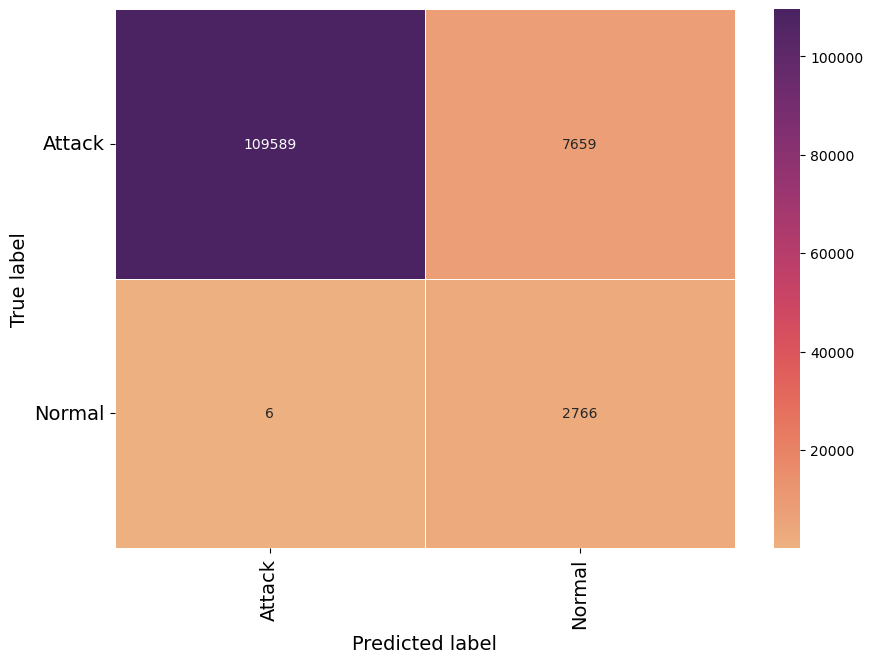

Model: xgb - DS: nf_bot_multi - Fold: 0


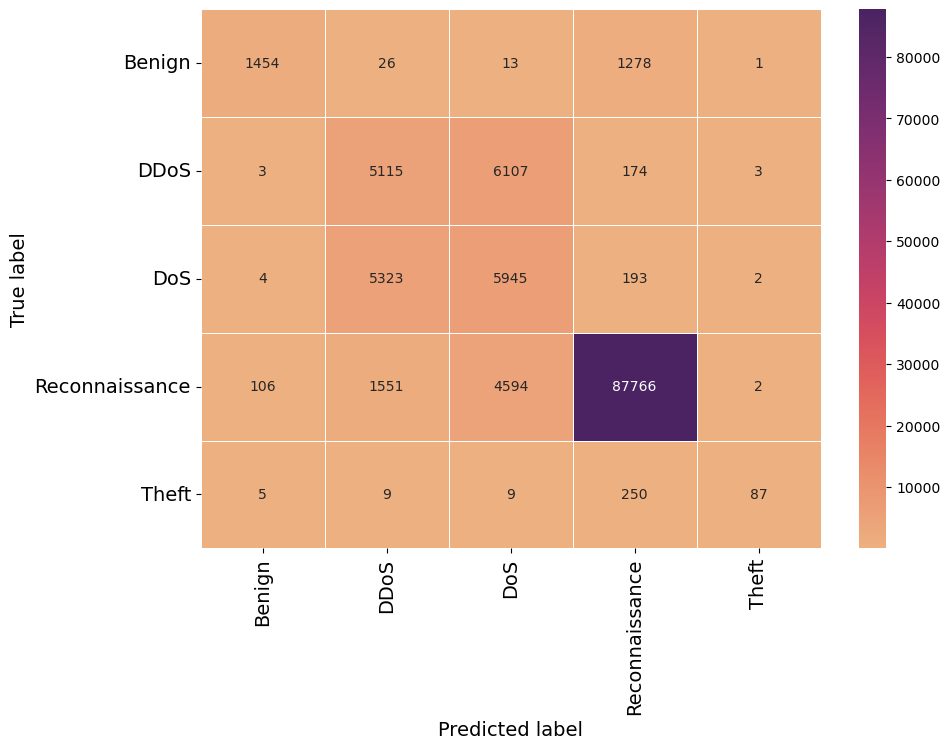

Model: xgb - DS: nf_ton_binary - Fold: 0


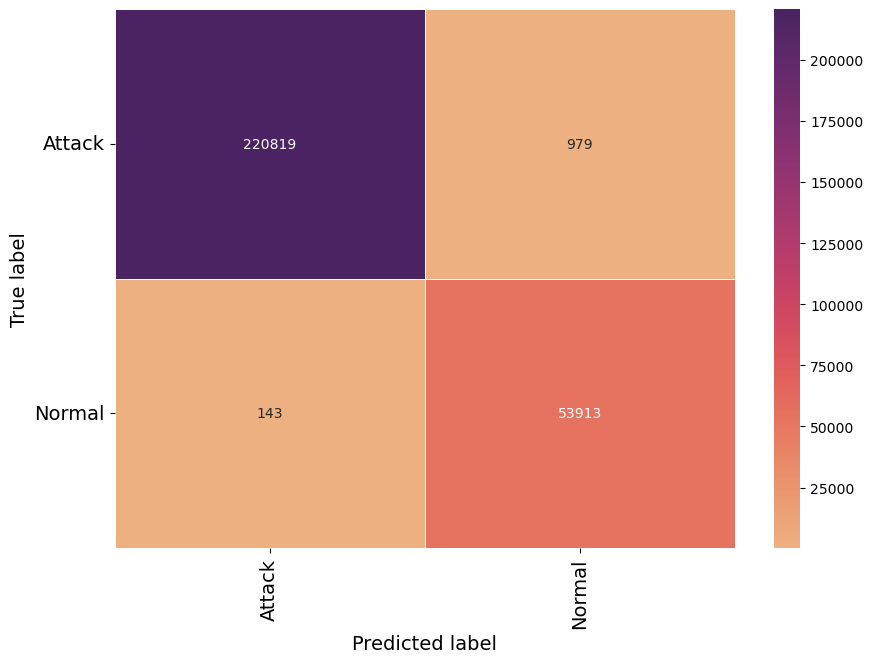

Model: xgb - DS: nf_ton_multi - Fold: 0


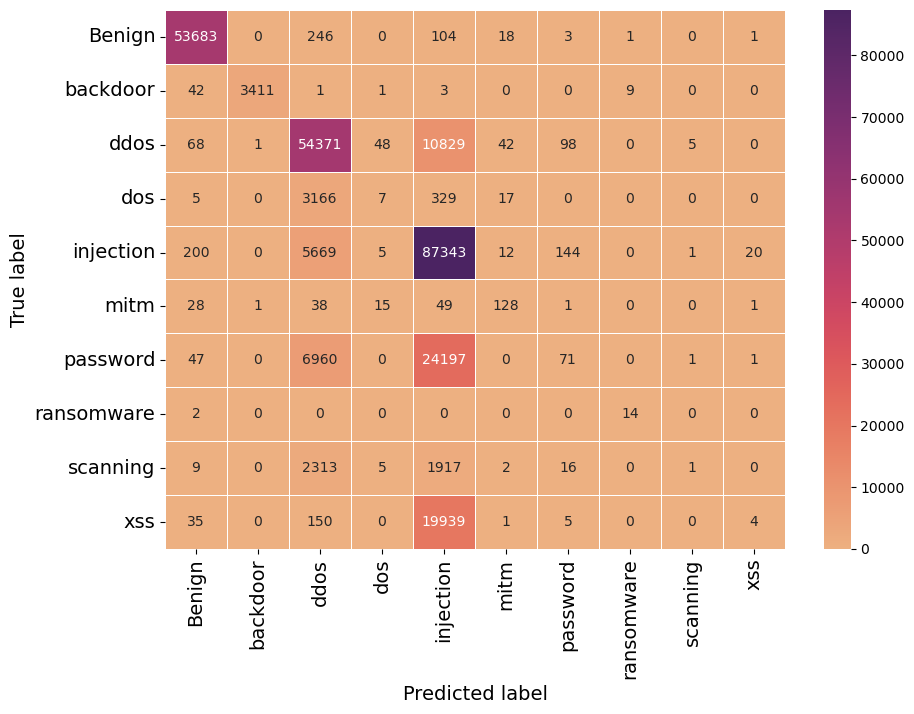



Model: EGraphSAGE - DS: nf_bot_binary - Fold: 0


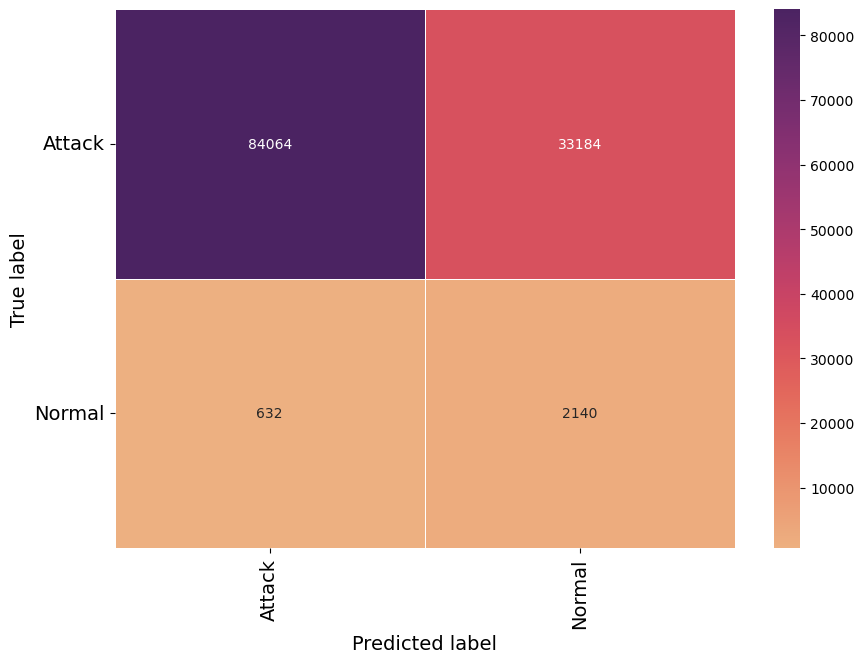

Model: EGraphSAGE - DS: nf_bot_multi - Fold: 0


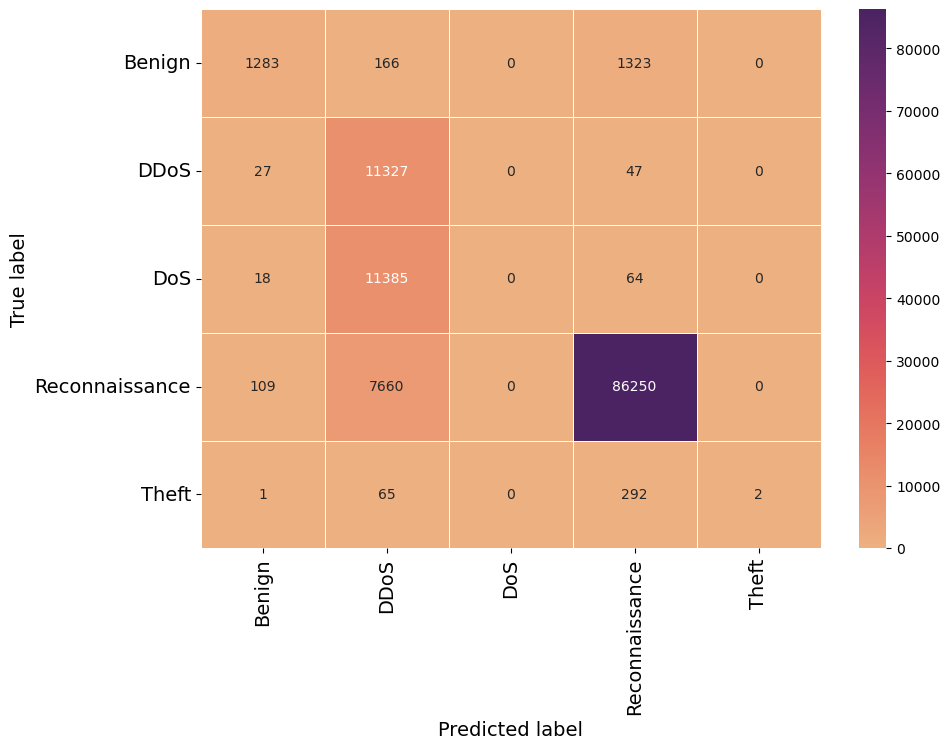

Model: EGraphSAGE - DS: nf_ton_binary - Fold: 0


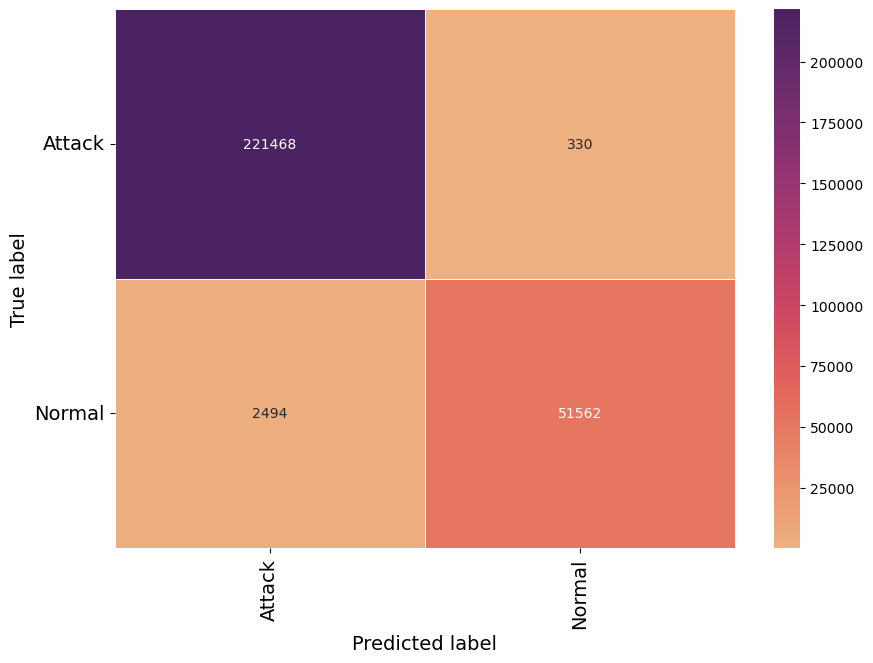

Model: EGraphSAGE - DS: nf_ton_multi - Fold: 0


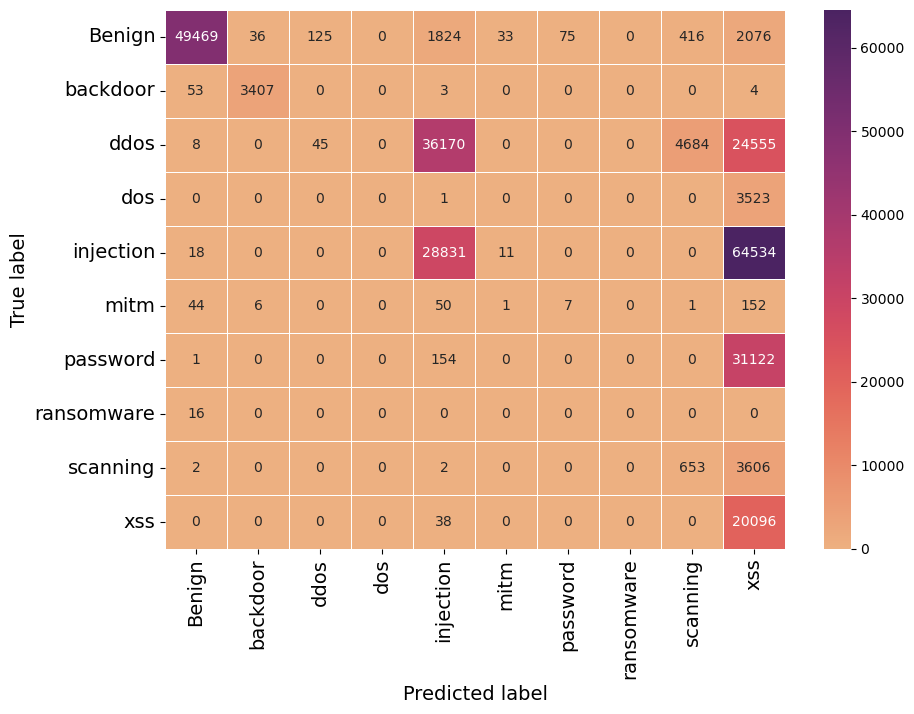



Model: tsids - DS: nf_bot_binary - Fold: 0


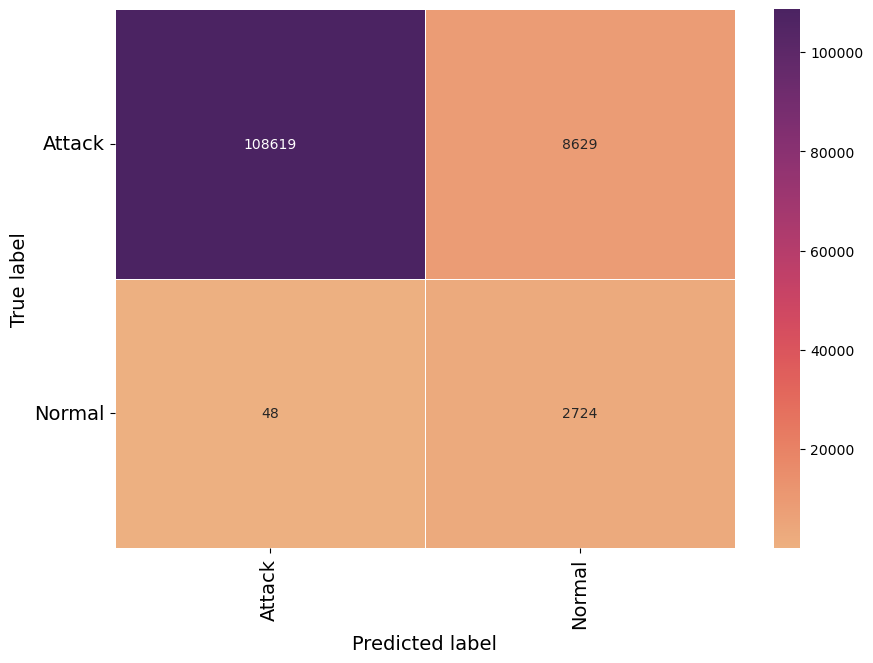

Model: tsids - DS: nf_bot_multi - Fold: 0


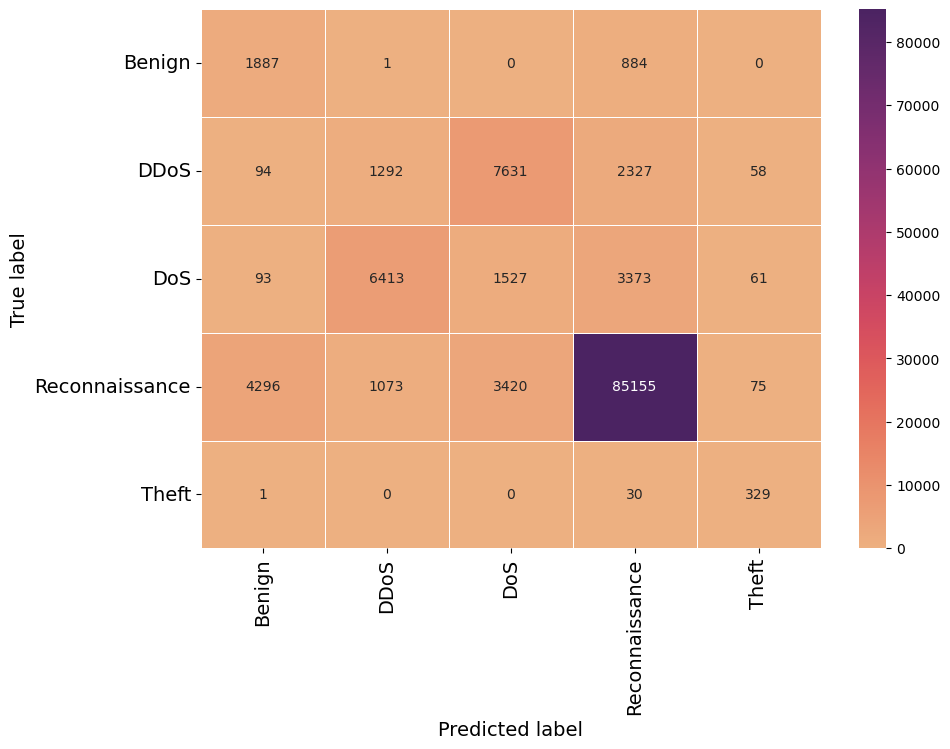

Model: tsids - DS: nf_ton_binary - Fold: 0


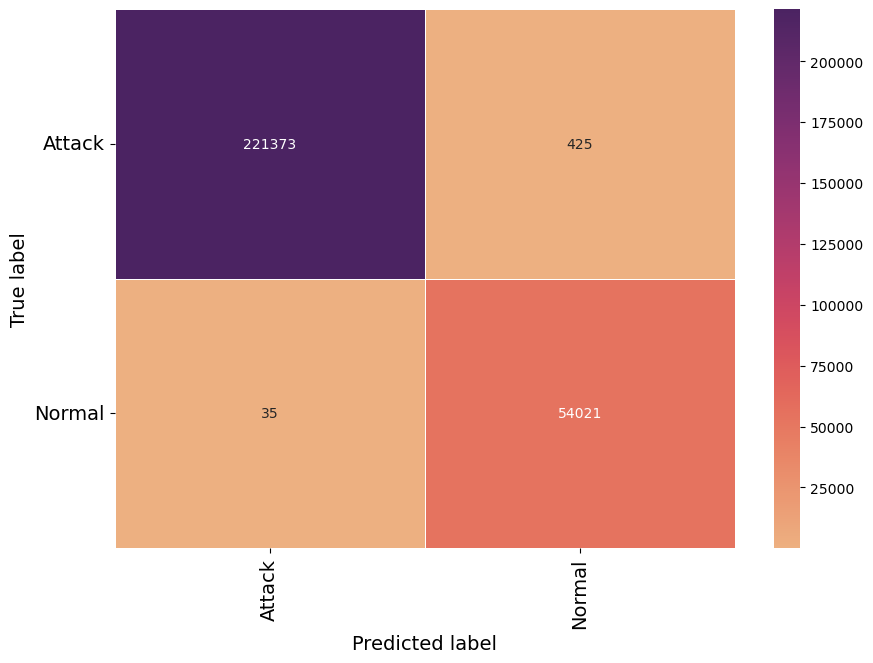

Model: tsids - DS: nf_ton_multi - Fold: 0


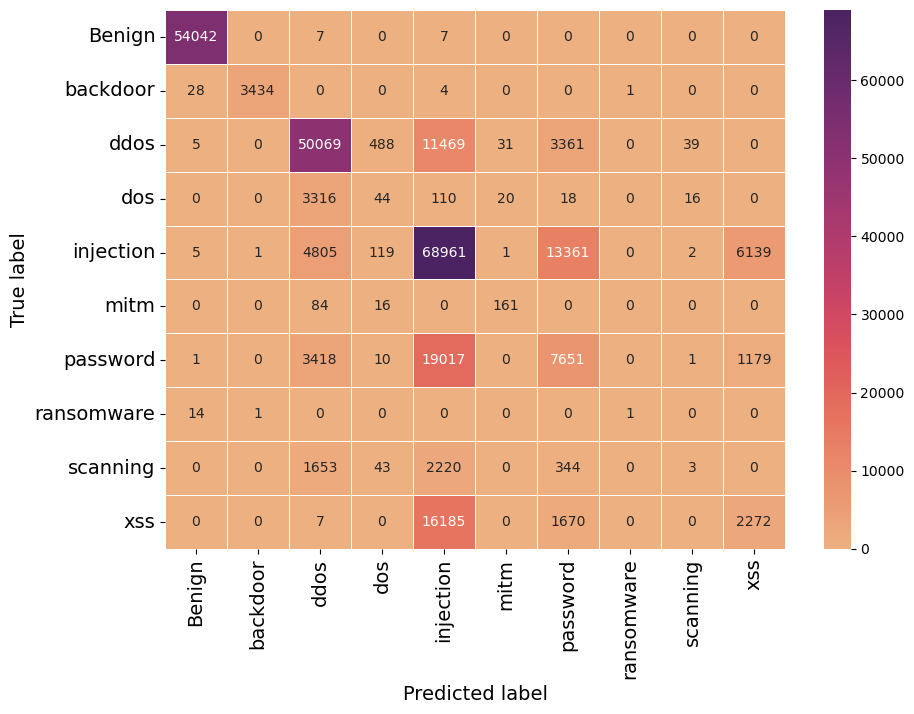

In [8]:
fold = 0
for model in models:
    for ds, f_ds in datasets.items():
        ds_file = f'../datasets/{f_ds}.pkl'
        print(f'Model: {model} - DS: {ds} - Fold: {fold}')
        pred_path = f'../output_cv/{model}_{ds}_cv{fold}.csv'

        df_test, gts, probs, preds, binary = read_output(ds_file, pred_path)
        result = calc_eval(gts, probs, preds, binary)
        result = [model, ds, fold] + list(result)
        plot_confusion_matrix(df_test)
    print('\n')

In [ ]:
# results = []
# paths = sorted(glob.glob('../output_cv/model=*.csv'))
# model = 'TS-IDS'
# for p in paths:
#     print(p)
#     pattern = re.compile("gat_(.+)_cv(\d+)")
#     ds = pattern.findall(p)[0][0]
#     fold = pattern.findall(p)[0][1]
#     f_ds = datasets[ds]
#     pred_path = p
#     ds_file = f'../datasets/{f_ds}.pkl'
    
#     df_test, gts, probs, preds, binary = read_output(ds_file, pred_path)
#     result = calc_eval(gts, probs, preds, binary)
#     result = [model, ds, p, fold] + list(result)
# #     plot_confusion_matrix(df_test)
#     results.append(result)

In [ ]:
# results = []
# paths = sorted(glob.glob('../output_cv/model=gat_*.csv'))
# model = 'TS-IDS'
# for p in paths:
#     print(p)
#     pattern = re.compile("gat_(.+)_cv(\d+)")
#     ds = pattern.findall(p)[0][0]
#     fold = pattern.findall(p)[0][1]
#     f_ds = datasets[ds]
#     pred_path = p
#     ds_file = f'../datasets/{f_ds}.pkl'
    
#     df_test, gts, probs, preds, binary = read_output(ds_file, pred_path)
#     result = calc_eval(gts, probs, preds, binary)
#     result = [model, ds, p, fold] + list(result)
# #     plot_confusion_matrix(df_test)
#     results.append(result)

In [ ]:
# df01 = pd.DataFrame(results)
# df01.columns = ['model', 'dataset', 'path', 'fold'] + metrics
# df02 = df01.sort_values('auc', ascending=False).groupby(['model', 'dataset', 'fold'], as_index=False).first()
# df_tsids = df02.groupby(['model', 'dataset'], as_index=False).agg({m: 'mean' for m in metrics})
# df_tsids.sort_values('dataset').T